In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [6]:
#spark related imports
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *

In [7]:
#init spark
conf = SparkConf().setMaster("local[4]").setAppName("Spark-OTT-Check")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [8]:
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [9]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
contact,unknown,unknown,unknown,unknown,unknown
day,5,5,5,5,5


In [11]:
type(df)

pyspark.sql.dataframe.DataFrame

In [14]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


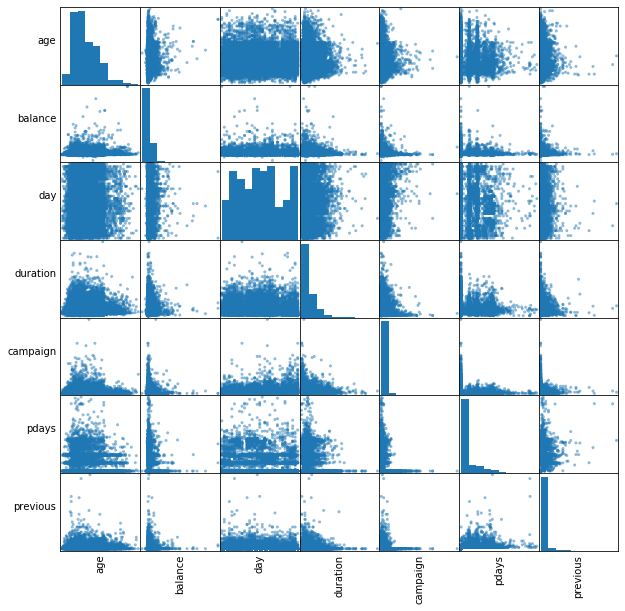

In [19]:
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(10, 10));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [20]:
#remove unuseful cols
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



<h2>Preparing Data for Machine Learning</h2>

<br/>

The process includes Category Indexing, One-Hot Encoding and VectorAssembler — a feature transformer that merges multiple columns into a vector column.

In [22]:
#prepare data for ML
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []
for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]
numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

The above code are taken from databricks’ official site and it indexes each categorical column using the StringIndexer, then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row. We use the StringIndexer again to encode our labels to label indices. Next, we use the VectorAssembler to combine all the feature columns into a single vector column.


<h2>Pipeline</h2>


We use Pipeline to chain multiple Transformers and Estimators together to specify our machine learning workflow. A Pipeline’s stages are specified as an ordered array.


In [23]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [24]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
marital,married,married,married,married,married
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no


In [25]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


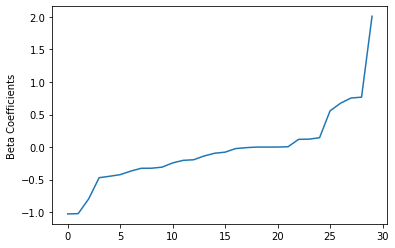

In [26]:
from pyspark.ml.classification import LogisticRegression
import numpy as np
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)


beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

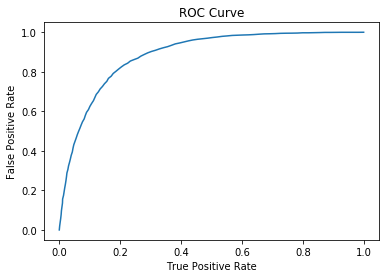

Training set areaUnderROC: 0.8849092421146739


In [27]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

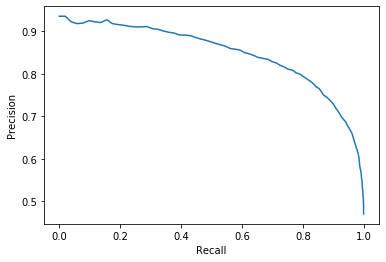

In [28]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [29]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[1.19871810716723...|       0.0|[0.76829666339830...|
| 40|management|  0.0|[2.20534940465796...|       0.0|[0.90072886169926...|
| 53|management|  0.0|[1.02590348276690...|       0.0|[0.73612093009497...|
| 32|management|  0.0|[1.25795481657702...|       0.0|[0.77867383994058...|
| 54|management|  0.0|[1.33232096924268...|       0.0|[0.79122429116078...|
| 40|management|  0.0|[1.57095096412779...|       0.0|[0.82791913346617...|
| 56|management|  0.0|[3.06095963426752...|       0.0|[0.95525333386804...|
| 50|management|  0.0|[-0.8102603273804...|       1.0|[0.30783502428597...|
| 47|management|  0.0|[0.67024288891379...|       0.0|[0.66155754396054...|
| 44|management|  0.0|[1.29756265761715...|       0.0|[0.78542449653716...|
+---+-------

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8858324614449619


In [31]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 37|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 53|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 32|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 54|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 40|management|  0.0|  [373.0,30.0]|       0.0|[0.92555831265508...|
| 56|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
| 50|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 47|management|  0.0|[788.0,1230.0]|       1.0|[0.39048562933597...|
| 44|management|  0.0|[2463.0,473.0]|       0.0|[0.83889645776566...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [32]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7910083562522027


In [33]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[13.2915787216373...|       0.0|[0.66457893608186...|
| 40|management|  0.0|[14.0018791618363...|       0.0|[0.70009395809181...|
| 53|management|  0.0|[11.8367340974375...|       0.0|[0.59183670487187...|
| 32|management|  0.0|[13.4281762046325...|       0.0|[0.67140881023162...|
| 54|management|  0.0|[13.4973217727009...|       0.0|[0.67486608863504...|
| 40|management|  0.0|[17.2770467528798...|       0.0|[0.86385233764399...|
| 56|management|  0.0|[17.6210103182795...|       0.0|[0.88105051591397...|
| 50|management|  0.0|[5.78832784749443...|       1.0|[0.28941639237472...|
| 47|management|  0.0|[12.1132051944551...|       0.0|[0.60566025972275...|
| 44|management|  0.0|[9.94327826316270...|       1.0|[0.49716391315813...|
+---+-------

In [34]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8773464667012633


In [35]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 37|management|  0.0|[0.57808138910181...|       0.0|[0.76063477260811...|
| 40|management|  0.0|[1.37467582901950...|       0.0|[0.93987672346171...|
| 53|management|  0.0|[-0.0012929624008...|       1.0|[0.49935351915983...|
| 32|management|  0.0|[0.61900313605401...|       0.0|[0.77521678642033...|
| 54|management|  0.0|[0.98157815641818...|       0.0|[0.87687413211579...|
| 40|management|  0.0|[0.96138354833170...|       0.0|[0.87244668327834...|
| 56|management|  0.0|[1.39120025731353...|       0.0|[0.94171733839668...|
| 50|management|  0.0|[-0.6141629093446...|       1.0|[0.22647458093662...|
| 47|management|  0.0|[-0.0439971283470...|       1.0|[0.47801561939801...|
| 44|management|  0.0|[0.26452511568224...|       0.0|[0.62926156628314...|
+---+-------

In [36]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8940728473145346


In [37]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [39]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.8981050997838095

To sum it up, we have learned how to build a binary classification application using PySpark and MLlib Pipelines API. We tried four algorithms and gradient boosting performed best on our data set.



References:


1)https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa